# FineTuning BERT for Multi-Class Classification with custom datasets

### [Link to Dataset](https://www.kaggle.com/datasets/savasy/ttc4900)

In [1]:
!pip install transformers datasets

   ---------------------------------------- 0.0/26.1 MB ? eta -:--:--
   --- ------------------------------------ 2.1/26.1 MB 12.9 MB/s eta 0:00:02
   -------- ------------------------------- 5.2/26.1 MB 13.6 MB/s eta 0:00:02
   ------------ --------------------------- 8.4/26.1 MB 13.9 MB/s eta 0:00:02
   ----------------- ---------------------- 11.5/26.1 MB 14.3 MB/s eta 0:00:02
   ---------------------- ----------------- 14.9/26.1 MB 14.6 MB/s eta 0:00:01
   ---------------------------- ----------- 18.6/26.1 MB 14.9 MB/s eta 0:00:01
   --------------------------------- ------ 22.0/26.1 MB 15.1 MB/s eta 0:00:01
   ---------------------------------------  26.0/26.1 MB 15.4 MB/s eta 0:00:01
   ---------------------------------------- 26.1/26.1 MB 14.8 MB/s eta 0:00:00

   --- ------------------------------------  1/12 [pyarrow]
   --- ------------------------------------  1/12 [pyarrow]
   --- ------------------------------------  1/12 [pyarrow]
   --- ----------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch, os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import Dataset

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Función para monitorear memoria GPU
def check_gpu_memory():
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        gpu_allocated = torch.cuda.memory_allocated(0) / 1024**3  # GB
        gpu_reserved = torch.cuda.memory_reserved(0) / 1024**3  # GB
        
        print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 Memoria total: {gpu_memory:.1f} GB")
        print(f"📊 Memoria asignada: {gpu_allocated:.1f} GB ({gpu_allocated/gpu_memory*100:.1f}%)")
        print(f"🔒 Memoria reservada: {gpu_reserved:.1f} GB ({gpu_reserved/gpu_memory*100:.1f}%)")
        
        if gpu_reserved > gpu_memory * 0.8:
            print("⚠️  ADVERTENCIA: Uso alto de memoria GPU")
        else:
            print("✅ Uso de memoria GPU dentro de límites normales")
    else:
        print("❌ No hay GPU disponible - usando CPU")

check_gpu_memory()

🎮 GPU: NVIDIA GeForce GTX 1650
💾 Memoria total: 4.0 GB
📊 Memoria asignada: 0.0 GB (0.0%)
🔒 Memoria reservada: 0.0 GB (0.0%)
✅ Uso de memoria GPU dentro de límites normales


In [5]:
# Cargar el dataset de clasificaciones ISO 25010
df_org = pd.read_csv("salida.csv")

# Renombrar columnas para que coincidan con el código original
df_org = df_org.rename(columns={
    'comentario': 'text',
    'clasificacion_ISO_25010': 'category'
})

# Limpiar datos y quitar espacios en blanco
df_org['category'] = df_org['category'].str.strip()
df_org['text'] = df_org['text'].str.strip()

# Filtrar filas con datos faltantes
df_org = df_org.dropna(subset=['text', 'category'])

# Mezclar el dataset
df_org = df_org.sample(frac=1.0, random_state=42).reset_index(drop=True)

print(f"Dataset cargado: {len(df_org)} ejemplos")
print(f"Distribución de clases:")
print(df_org['category'].value_counts())

df_org.head()

Dataset cargado: 4774 ejemplos
Distribución de clases:
category
autenticidad        3152
integridad           731
responsabilidad      400
resistencia          225
confidencialidad     147
no_repudio           119
Name: count, dtype: int64


,id,text,category
0,34,"Nunca llega el tokken digital, no deja realiza...",autenticidad
1,556,pésimo servicio de que sirve que habiliten pli...,autenticidad
2,4693,Nunca tuve problemas con la app pero el celula...,autenticidad
3,3132,"Pésima actualización, para activar el token di...",autenticidad
4,3922,Le doy 2 estrellas porque hay importes que no ...,integridad


In [6]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['autenticidad',
 'integridad',
 'responsabilidad',
 'resistencia',
 'confidencialidad',
 'no_repudio']


## Why we need id2label and labe2ids in NLP Projects

In NLP tasks, especially those involving classification problems, id2label and label2id dictionaries are used to map class labels (categories) to integer IDs and vice versa. These mappings are essential for various stages of the NLP pipeline, such as data preprocessing, model training, and evaluation.

Data preprocessing: In order to feed text data into an NLP model, the text must first be tokenized and then converted into numerical values. Similarly, class labels must also be transformed into numerical representations. The label2id dictionary helps in converting the original class labels into integer IDs.

Model training: NLP models usually output probability distributions over classes as their predictions. During training, the model's predictions are compared against the ground truth labels (which have been converted to integer IDs) to compute the loss and optimize the model parameters.

Model evaluation and interpretation: Once the model has been trained, its predictions (in the form of integer IDs) need to be mapped back to their original class labels to make the results interpretable. The id2label dictionary is used to perform this conversion.


For `BertForSequenceClassification` model as well I need these exact mapping of id2labels and labels2id in dictionary form.

### Hence, fefore you start training your model, create a map of the expected ids to their labels with id2label and label2id:

In [7]:
for key, value in enumerate(labels):
    print(value)

autenticidad
integridad
responsabilidad
resistencia
confidencialidad
no_repudio


In [8]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [8]:
label2id

{'autenticidad': 0,
 'integridad': 1,
 'responsabilidad': 2,
 'resistencia': 3,
 'confidencialidad': 4,
 'no_repudio': 5}

In [9]:
id2label

{0: 'autenticidad',
 1: 'integridad',
 2: 'responsabilidad',
 3: 'resistencia',
 4: 'confidencialidad',
 5: 'no_repudio'}

In [10]:
df_org.head()

,id,text,category
0,34,"Nunca llega el tokken digital, no deja realiza...",autenticidad
1,556,pésimo servicio de que sirve que habiliten pli...,autenticidad
2,4693,Nunca tuve problemas con la app pero el celula...,autenticidad
3,3132,"Pésima actualización, para activar el token di...",autenticidad
4,3922,Le doy 2 estrellas porque hay importes que no ...,integridad


### Create a new column to represent the categories in numerical form

I need a 'label' column heading with numeric value else while running the epochs with `trainer.train()` I will get below error

```
BertForSequenceClassification ValueError: The model did not return 

```


### In below I am doing it manually, but I could have also done it with pd.factorize() as below

Pandas factorize method is used for encoding categorical variables as integers. It assigns a unique integer value to each distinct category in a given Series or DataFrame, effectively transforming non-numeric data into numeric values.

In [15]:
# df_org['labels_num'] = pd.factorize(df_org.category)[0]
# df_org.head()

In [11]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [12]:
df_org.head()

,id,text,category,labels
0,34,"Nunca llega el tokken digital, no deja realiza...",autenticidad,0
1,556,pésimo servicio de que sirve que habiliten pli...,autenticidad,0
2,4693,Nunca tuve problemas con la app pero el celula...,autenticidad,0
3,3132,"Pésima actualización, para activar el token di...",autenticidad,0
4,3922,Le doy 2 estrellas porque hay importes que no ...,integridad,1


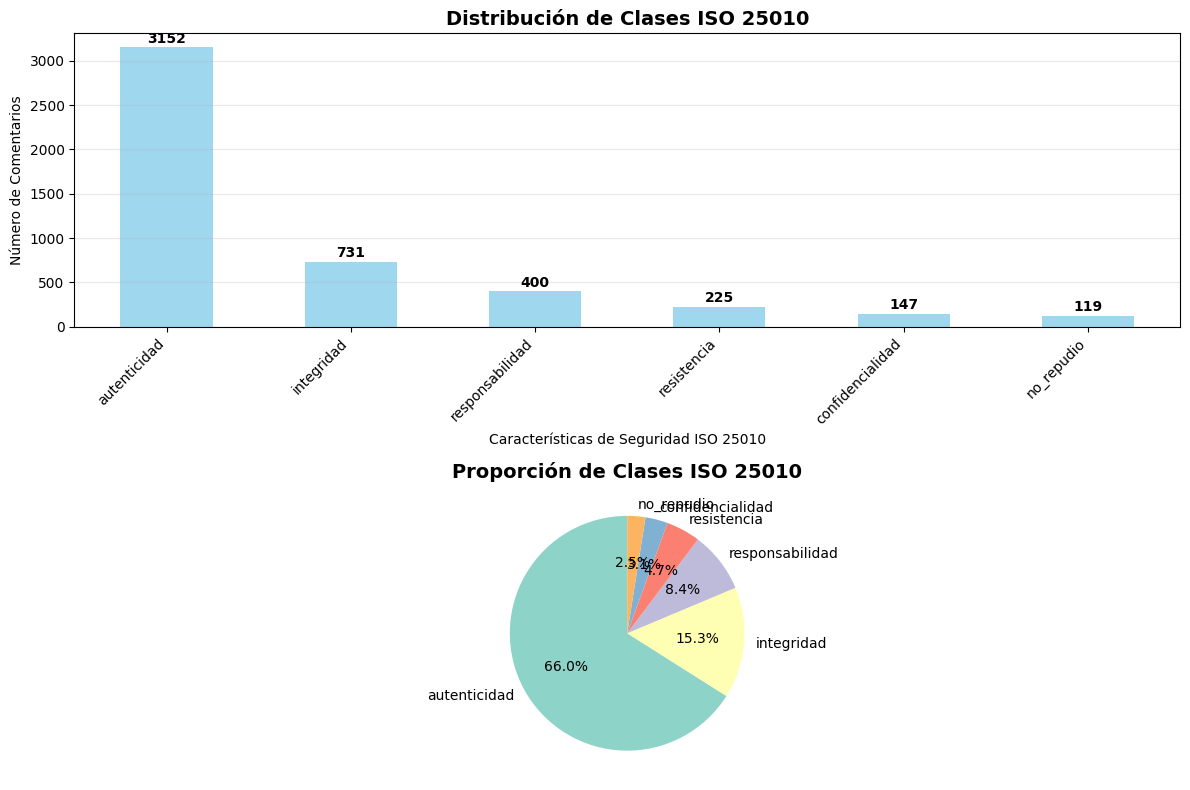


Resumen del dataset:
Total de comentarios: 4,774
Clases balanceadas: ❌ No
Clase más frecuente: autenticidad (3,152 ejemplos)
Clase menos frecuente: no_repudio (119 ejemplos)


In [13]:
# Visualizar distribución de clases ISO 25010
plt.figure(figsize=(12, 8))
class_counts = df_org.category.value_counts()

# Gráfico de barras
plt.subplot(2, 1, 1)
class_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribución de Clases ISO 25010', fontsize=14, fontweight='bold')
plt.xlabel('Características de Seguridad ISO 25010')
plt.ylabel('Número de Comentarios')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Mostrar valores en las barras
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
plt.subplot(2, 1, 2)
class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Proporción de Clases ISO 25010', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nResumen del dataset:")
print(f"Total de comentarios: {len(df_org):,}")
print(f"Clases balanceadas: {'✅ Sí' if class_counts.std() < class_counts.mean() else '❌ No'}")
print(f"Clase más frecuente: {class_counts.index[0]} ({class_counts.iloc[0]:,} ejemplos)")
print(f"Clase menos frecuente: {class_counts.index[-1]} ({class_counts.iloc[-1]:,} ejemplos)")

In [14]:
# Usar DistilBERT en español (más ligero para tu GPU)
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
# Alternativa: "distilbert-base-multilingual-cased" si prefieres DistilBERT puro

tokenizer = DistilBertTokenizerFast.from_pretrained(model_name, max_length=512)

print(f"Tokenizer cargado: {model_name}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


Tokenizer cargado: dccuchile/bert-base-spanish-wwm-uncased


In [15]:
# Cargar el modelo DistilBERT para clasificación
model = DistilBertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=NUM_LABELS, 
    id2label=id2label, 
    label2id=label2id
)

# Mover modelo a GPU si está disponible
model.to(device)

print(f"Modelo cargado: {model_name}")
print(f"Número de parámetros: {model.num_parameters():,}")
print(f"Dispositivo: {device}")
print(f"Número de clases: {NUM_LABELS}")

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin1.weight', 'transfor

Modelo cargado: dccuchile/bert-base-spanish-wwm-uncased
Número de parámetros: 109,853,958
Dispositivo: cuda
Número de clases: 6


## Useful information and understanding you know about the model from the above output

**Model components:** The model consists of several key components, such as:

* Embeddings (word, position, and token type embeddings)

* Encoder layers (12 layers in this case, each with self-attention, intermediate, and output components)

* Layer normalization and dropout layers for regularization

* GELU activation functions used in the intermediate layers

**Model dimensions:**

* Word embeddings: The model has an embedding size of 768 dimensions and a vocabulary size of 32,000 tokens.

* Position embeddings: The model can handle input sequences of up to 512 tokens in length.

* Encoder layers: The model has 12 encoder layers, each with a hidden size of 768 and an intermediate layer size of 3072.

* Task-specific classification layer: The BertForSequenceClassification model is designed for sequence classification tasks. It takes the final hidden state of the [CLS] token and passes it through a linear layer and a softmax function to produce class probabilities. In this case, the model is configured with a custom number of labels (NUM_LABELS) and label mappings (id2label, label2id).

--------------------------

## Lets understand the flow of a raw input-text > through the pretrained BERT Model > and finally coming out on the other side of the model as a class prediction in the context of this task-specific fine-tuning.

In BERT-based models like BertForSequenceClassification, the [CLS] token (short for "classification") serves as a special token that is prepended to the input sequence. It is designed to be used as an aggregate representation of the entire input sequence for classification tasks.

Here's a step-by-step breakdown of how the [CLS] token is handled during fine-tuning for a specific classification task:

Tokenization: During the pre-processing of the input text, the tokenizer inserts the [CLS] token at the beginning of the input sequence. For example, if the input text is "This is a sample sentence.", the tokenized input would look like: "[CLS] This is a sample sentence."

**Embeddings:** The tokenized input sequence, including the [CLS] token, is passed through the BERT model's embedding layers, which convert the tokens into continuous-valued word vectors.

**Encoder layers:** The embedded input sequence is then processed through the BERT model's encoder layers, which consist of self-attention mechanisms and feed-forward neural networks. During this process, the model learns to capture the semantic and syntactic information present in the input sequence, as well as any relationships between the tokens.

**Final hidden state of [CLS]:** At the end of the BERT model's encoder layers, each token has a corresponding hidden state vector. For the [CLS] token, its final hidden state is used as an aggregated representation of the entire input sequence. This vector is then passed to the task-specific classification layer.

**Linear layer:** The final hidden state of the [CLS] token is fed into a linear layer, which maps the 768-dimensional vector (assuming the base BERT model) to a vector of size equal to the number of target classes. This is essentially a weight matrix multiplication followed by a bias term addition.

**Softmax function:** The output of the linear layer is then passed through a softmax function, which converts the raw output values into class probabilities. The softmax function ensures that the sum of probabilities across all classes equals 1.

**Prediction:** The class with the highest probability is chosen as the final prediction for the given input sequence.

During task-specific fine-tuning, the model learns to adjust its weights and biases based on the training data and the target labels. This involves updating both the BERT model's pre-trained parameters and the task-specific classification layer's parameters through backpropagation and optimization techniques like gradient descent. This fine-tuning process allows the model to adapt to the specific classification task and improve its performance on the given dataset.

-------------------

## In the above task specific fine tuning do all of the weights of the pretrained BERT model gets modified during this finetuning process or only some of the weights get modified ?


During task-specific fine-tuning, all of the weights of the pre-trained BERT model are potentially subject to modification, including the weights in the embedding layers, the encoder layers, and the classification layer. However, the extent to which each weight is modified depends on the learning rate, the specific task, and the training data.

In general, fine-tuning a pre-trained model like BERT involves updating its weights to better adapt to the target task. When fine-tuning begins, the initial weights of the model come from the pre-trained model, which has already learned general language representations from a large-scale unsupervised task (e.g., masked language modeling).

During fine-tuning, the model is exposed to the particular task-specific training data and labels, and the weights are updated using backpropagation and gradient descent.

Typically, the learning rate for fine-tuning is set to be smaller than the learning rate used during pre-training. This is because the pre-trained model already has a good understanding of language, and the fine-tuning process aims to make small, incremental adjustments to the weights to adapt the model to the specific task without losing the valuable general language knowledge.

## Splitting df_org


In [16]:
from sklearn.model_selection import train_test_split

# MEJOR OPCIÓN: Partición estratificada que mantiene proporción de clases
# Esto asegura que cada subconjunto tenga representación proporcional de todas las clases

# Primera división: 70% train, 30% temp (que luego se divide en val y test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    list(df_org.text), 
    list(df_org.labels),
    test_size=0.3, 
    random_state=42,
    stratify=df_org.labels  # ¡CLAVE! Mantiene proporción de clases
)

# Segunda división del 30% restante: 15% validación, 15% test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, 
    temp_labels,
    test_size=0.5,  # 50% del 30% = 15% del total
    random_state=42,
    stratify=temp_labels  # Mantiene proporción también aquí
)

print("📊 PARTICIÓN ESTRATIFICADA:")
print(f"Train: {len(train_texts)} ejemplos ({len(train_texts)/len(df_org)*100:.1f}%)")
print(f"Val:   {len(val_texts)} ejemplos ({len(val_texts)/len(df_org)*100:.1f}%)")
print(f"Test:  {len(test_texts)} ejemplos ({len(test_texts)/len(df_org)*100:.1f}%)")

# Verificar distribución de clases en cada subconjunto
import pandas as pd
train_dist = pd.Series(train_labels).value_counts()
val_dist = pd.Series(val_labels).value_counts()
test_dist = pd.Series(test_labels).value_counts()

print("\n🎯 DISTRIBUCIÓN POR CLASE:")
print("Clase          | Train | Val | Test | Total")
print("-" * 45)
for label_id in sorted(df_org.labels.unique()):
    label_name = id2label[label_id]
    train_count = train_dist.get(label_id, 0)
    val_count = val_dist.get(label_id, 0)
    test_count = test_dist.get(label_id, 0)
    total_count = train_count + val_count + test_count
    print(f"{label_name:<14} | {train_count:5d} | {val_count:3d} | {test_count:4d} | {total_count:5d}")

📊 PARTICIÓN ESTRATIFICADA:
Train: 3341 ejemplos (70.0%)
Val:   716 ejemplos (15.0%)
Test:  717 ejemplos (15.0%)

🎯 DISTRIBUCIÓN POR CLASE:
Clase          | Train | Val | Test | Total
---------------------------------------------
autenticidad   |  2206 | 473 |  473 |  3152
integridad     |   512 | 109 |  110 |   731
responsabilidad |   280 |  60 |   60 |   400
resistencia    |   157 |  34 |   34 |   225
confidencialidad |   103 |  22 |   22 |   147
no_repudio     |    83 |  18 |   18 |   119


In [17]:
# TÉCNICAS ADICIONALES PARA DATASET DESBALANCEADO

# 1. Calcular pesos de clase para loss function balanceado
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convertir a diccionario para usar en el entrenamiento
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("⚖️ PESOS DE CLASE CALCULADOS:")
for label_id, weight in class_weights_dict.items():
    label_name = id2label[label_id]
    print(f"{label_name:<15}: {weight:.3f}")

# 2. Análisis de viabilidad por clase
print("\n🔍 ANÁLISIS DE VIABILIDAD:")
min_examples_needed = 50  # Mínimo recomendado por clase para deep learning

for label_id in sorted(df_org.labels.unique()):
    label_name = id2label[label_id]
    train_count = train_dist.get(label_id, 0)
    
    if train_count < min_examples_needed:
        print(f"⚠️  {label_name}: {train_count} ejemplos (INSUFICIENTE - considera data augmentation)")
    elif train_count < 100:
        print(f"🟡 {label_name}: {train_count} ejemplos (LÍMITE - monitorea overfitting)")
    else:
        print(f"✅ {label_name}: {train_count} ejemplos (SUFICIENTE)")

# 3. Recomendaciones específicas
print(f"\n💡 RECOMENDACIONES:")
print(f"• Usar class_weight='balanced' en el modelo")
print(f"• Considerar data augmentation para clases minoritarias")
print(f"• Usar métricas balanceadas (F1-macro, precisión/recall por clase)")
print(f"• Monitorear overfitting en clases con pocos ejemplos")
print(f"• Considerar combinar clases muy similares si es apropiado")

⚖️ PESOS DE CLASE CALCULADOS:
autenticidad   : 0.252
integridad     : 1.088
responsabilidad: 1.989
resistencia    : 3.547
confidencialidad: 5.406
no_repudio     : 6.709

🔍 ANÁLISIS DE VIABILIDAD:
✅ autenticidad: 2206 ejemplos (SUFICIENTE)
✅ integridad: 512 ejemplos (SUFICIENTE)
✅ responsabilidad: 280 ejemplos (SUFICIENTE)
✅ resistencia: 157 ejemplos (SUFICIENTE)
✅ confidencialidad: 103 ejemplos (SUFICIENTE)
🟡 no_repudio: 83 ejemplos (LÍMITE - monitorea overfitting)

💡 RECOMENDACIONES:
• Usar class_weight='balanced' en el modelo
• Considerar data augmentation para clases minoritarias
• Usar métricas balanceadas (F1-macro, precisión/recall por clase)
• Monitorear overfitting en clases con pocos ejemplos
• Considerar combinar clases muy similares si es apropiado


In [18]:
len(train_texts)


3341

In [19]:
len(train_texts), len(val_texts), len(test_texts)

(3341, 716, 717)

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [21]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


## From above DataLoader() The line `item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}`

Here I use a dictionary comprehension that constructs a new dictionary called `item`. This line converts the encoding values associated with the input text at the given index idx into PyTorch tensors.

self.encodings is a dictionary containing tokenized input text with keys like 'input_ids', 'token_type_ids', and 'attention_mask'. These keys represent different aspects of the encoded text that are needed for processing by the BERT model. The values associated with these keys are lists or arrays of integers.

.items() is a method that returns a view object displaying a list of a dictionary's key-value pairs as tuples.

The dictionary comprehension iterates through the key-value pairs of self.encodings with the variables key and val. For each key-value pair, it creates a new key-value pair in the item dictionary, where the key remains the same, and the value is a PyTorch tensor created from the elements at index idx of the original value.

In essence, this line of code is converting the relevant parts of the input encodings (e.g., input IDs, attention masks) at the given index idx into PyTorch tensors and storing them in a new dictionary called item. This format is necessary for input to the BERT model during training or evaluation.

Here's an example of the output format for self.encodings:


```
{
    'input_ids': [
        [101, 2023, 2003, 1037, 2742, 102],
        [101, 1045, 2066, 5009, 2102, 102],
        [101, 2129, 2024, 2017, 1029, 102]
    ],
    'token_type_ids': [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ],
    'attention_mask': [
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]
    ]
}
```

In this example, there are three input sentences, each encoded into three different features: input_ids, token_type_ids, and attention_mask.

* input_ids: Lists of token IDs that represent the input text. The integers correspond to the tokens in the tokenizer's vocabulary.

* token_type_ids: Lists of token type IDs that indicate the type of each token. In this case, they are all 0 since there is only one sentence per input. In tasks that require sentence pairs, you would see different token type IDs for different sentences.

* attention_mask: Lists of binary values that indicate whether a given token should be attended to (1) or not (0). In this example, all tokens are attended to, so all the values are 1. Padding tokens would have a value of 0 in the attention_mask.

Note that this example assumes that the maximum sequence length is 6 tokens, and there's no need for padding or truncation. In practice, you would have longer sequences, and padding would be necessary to make all the input sequences have the same length.

In [22]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training with Trainer Class

In [23]:
from transformers import TrainingArguments, Trainer

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## compute_metrics

argmax(): The NumPy method argmax() returns the index of the maximum value along a given axis. In a classification problem, we are interested in finding the class with the highest probability for each observation.

(-1): The (-1) inside argmax() represents the axis along which the operation should be performed. In Python, negative indices are used to access elements from the end. So, (-1) here means the last axis, which is the columns in a 2D array.

In [25]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
from transformers import Trainer
import torch

# Custom Trainer para manejar class weights - VERSIÓN CORREGIDA
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Función de pérdida personalizada que acepta todos los parámetros de la nueva versión
        de transformers, incluyendo num_items_in_batch
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Aplicar class weights si están disponibles
        if self.class_weights is not None:
            # Convertir class weights a tensor en el dispositivo correcto
            weights = torch.tensor(list(self.class_weights.values()), 
                                 dtype=torch.float32, device=logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# Crear trainer con pesos de clase para manejar desbalance
trainer = WeightedTrainer(
    model=model,                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics,
    class_weights=class_weights_dict  # ¡NUEVO! Pesos para clases desbalanceadas
)

print("✅ Trainer corregido y configurado con pesos de clase para dataset desbalanceado")
print("📊 Esto ayudará al modelo a aprender mejor las clases minoritarias")
print("🔧 Función compute_loss actualizada para compatibilidad con transformers v4.46+")

✅ Trainer corregido y configurado con pesos de clase para dataset desbalanceado
📊 Esto ayudará al modelo a aprender mejor las clases minoritarias
🔧 Función compute_loss actualizada para compatibilidad con transformers v4.46+


In [29]:
trainer.train()

  0%|          | 0/627 [00:00<?, ?it/s]

{'loss': 1.8266, 'grad_norm': 12.383475303649902, 'learning_rate': 2.45e-05, 'epoch': 0.24}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.8027814626693726, 'eval_Accuracy': 0.07541899441340782, 'eval_F1': 0.03224201888489209, 'eval_Precision': 0.16230478859725536, 'eval_Recall': 0.17044475765405998, 'eval_runtime': 63.9702, 'eval_samples_per_second': 11.193, 'eval_steps_per_second': 0.36, 'epoch': 0.24}
{'loss': 1.8367, 'grad_norm': 8.05030345916748, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.48}
{'loss': 1.8367, 'grad_norm': 8.05030345916748, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.48}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.8749570846557617, 'eval_Accuracy': 0.06005586592178771, 'eval_F1': 0.021518713263635737, 'eval_Precision': 0.1746817538896747, 'eval_Recall': 0.16983791402396053, 'eval_runtime': 63.7568, 'eval_samples_per_second': 11.23, 'eval_steps_per_second': 0.361, 'epoch': 0.48}
{'loss': 1.8492, 'grad_norm': 9.179108619689941, 'learning_rate': 4.535104364326376e-05, 'epoch': 0.72}
{'loss': 1.8492, 'grad_norm': 9.179108619689941, 'learning_rate': 4.535104364326376e-05, 'epoch': 0.72}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.842164158821106, 'eval_Accuracy': 0.664804469273743, 'eval_F1': 0.14186842527904922, 'eval_Precision': 0.2772323515661524, 'eval_Recall': 0.17125382262996944, 'eval_runtime': 64.2584, 'eval_samples_per_second': 11.143, 'eval_steps_per_second': 0.358, 'epoch': 0.72}
{'loss': 1.7368, 'grad_norm': 5.730801582336426, 'learning_rate': 4.060721062618596e-05, 'epoch': 0.96}
{'loss': 1.7368, 'grad_norm': 5.730801582336426, 'learning_rate': 4.060721062618596e-05, 'epoch': 0.96}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.659507393836975, 'eval_Accuracy': 0.6410614525139665, 'eval_F1': 0.22808380480232052, 'eval_Precision': 0.2160033145390969, 'eval_Recall': 0.2771213845301748, 'eval_runtime': 63.8828, 'eval_samples_per_second': 11.208, 'eval_steps_per_second': 0.36, 'epoch': 0.96}
{'loss': 1.7614, 'grad_norm': 7.293763160705566, 'learning_rate': 3.5863377609108165e-05, 'epoch': 1.2}
{'loss': 1.7614, 'grad_norm': 7.293763160705566, 'learning_rate': 3.5863377609108165e-05, 'epoch': 1.2}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7007415294647217, 'eval_Accuracy': 0.5153631284916201, 'eval_F1': 0.18630201442701444, 'eval_Precision': 0.18941330529888045, 'eval_Recall': 0.269105786547647, 'eval_runtime': 63.8671, 'eval_samples_per_second': 11.211, 'eval_steps_per_second': 0.36, 'epoch': 1.2}
{'loss': 1.5726, 'grad_norm': 6.717439651489258, 'learning_rate': 3.1119544592030364e-05, 'epoch': 1.44}
{'loss': 1.5726, 'grad_norm': 6.717439651489258, 'learning_rate': 3.1119544592030364e-05, 'epoch': 1.44}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6104878187179565, 'eval_Accuracy': 0.6089385474860335, 'eval_F1': 0.2207161231433076, 'eval_Precision': 0.21360949417355235, 'eval_Recall': 0.2751068597511826, 'eval_runtime': 63.8603, 'eval_samples_per_second': 11.212, 'eval_steps_per_second': 0.36, 'epoch': 1.44}
{'loss': 1.5469, 'grad_norm': 12.061553001403809, 'learning_rate': 2.637571157495256e-05, 'epoch': 1.67}
{'loss': 1.5469, 'grad_norm': 12.061553001403809, 'learning_rate': 2.637571157495256e-05, 'epoch': 1.67}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6132785081863403, 'eval_Accuracy': 0.7094972067039106, 'eval_F1': 0.3055916336573166, 'eval_Precision': 0.30226469116033733, 'eval_Recall': 0.31563300204190525, 'eval_runtime': 63.8501, 'eval_samples_per_second': 11.214, 'eval_steps_per_second': 0.36, 'epoch': 1.67}
{'loss': 1.5242, 'grad_norm': 11.515780448913574, 'learning_rate': 2.1631878557874763e-05, 'epoch': 1.91}
{'loss': 1.5242, 'grad_norm': 11.515780448913574, 'learning_rate': 2.1631878557874763e-05, 'epoch': 1.91}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.549803376197815, 'eval_Accuracy': 0.5810055865921788, 'eval_F1': 0.2237860548100258, 'eval_Precision': 0.21357561505459796, 'eval_Recall': 0.3172960798131797, 'eval_runtime': 63.878, 'eval_samples_per_second': 11.209, 'eval_steps_per_second': 0.36, 'epoch': 1.91}
{'loss': 1.3887, 'grad_norm': 7.149379253387451, 'learning_rate': 1.6888045540796965e-05, 'epoch': 2.15}
{'loss': 1.3887, 'grad_norm': 7.149379253387451, 'learning_rate': 1.6888045540796965e-05, 'epoch': 2.15}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6206235885620117, 'eval_Accuracy': 0.6494413407821229, 'eval_F1': 0.23602955795524383, 'eval_Precision': 0.21396366382373844, 'eval_Recall': 0.30970512235902115, 'eval_runtime': 63.8849, 'eval_samples_per_second': 11.208, 'eval_steps_per_second': 0.36, 'epoch': 2.15}
{'loss': 1.3925, 'grad_norm': 41.08927917480469, 'learning_rate': 1.2144212523719166e-05, 'epoch': 2.39}
{'loss': 1.3925, 'grad_norm': 41.08927917480469, 'learning_rate': 1.2144212523719166e-05, 'epoch': 2.39}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6195068359375, 'eval_Accuracy': 0.6843575418994413, 'eval_F1': 0.30255349509591606, 'eval_Precision': 0.3122759977197997, 'eval_Recall': 0.350149723239245, 'eval_runtime': 63.8591, 'eval_samples_per_second': 11.212, 'eval_steps_per_second': 0.36, 'epoch': 2.39}
{'loss': 1.2749, 'grad_norm': 13.081820487976074, 'learning_rate': 7.400379506641367e-06, 'epoch': 2.63}
{'loss': 1.2749, 'grad_norm': 13.081820487976074, 'learning_rate': 7.400379506641367e-06, 'epoch': 2.63}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.5917270183563232, 'eval_Accuracy': 0.6801675977653632, 'eval_F1': 0.28476030161526344, 'eval_Precision': 0.27048424099613166, 'eval_Recall': 0.3501383581925506, 'eval_runtime': 61.5501, 'eval_samples_per_second': 11.633, 'eval_steps_per_second': 0.374, 'epoch': 2.63}
{'loss': 1.3632, 'grad_norm': 12.657721519470215, 'learning_rate': 2.7514231499051238e-06, 'epoch': 2.87}
{'loss': 1.3632, 'grad_norm': 12.657721519470215, 'learning_rate': 2.7514231499051238e-06, 'epoch': 2.87}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.5582482814788818, 'eval_Accuracy': 0.6913407821229051, 'eval_F1': 0.28362464864211173, 'eval_Precision': 0.2643672700603394, 'eval_Recall': 0.34872197419418144, 'eval_runtime': 61.552, 'eval_samples_per_second': 11.632, 'eval_steps_per_second': 0.374, 'epoch': 2.87}
{'train_runtime': 5511.3438, 'train_samples_per_second': 1.819, 'train_steps_per_second': 0.114, 'train_loss': 1.5786385543798906, 'epoch': 3.0}
{'train_runtime': 5511.3438, 'train_samples_per_second': 1.819, 'train_steps_per_second': 0.114, 'train_loss': 1.5786385543798906, 'epoch': 3.0}


TrainOutput(global_step=627, training_loss=1.5786385543798906, metrics={'train_runtime': 5511.3438, 'train_samples_per_second': 1.819, 'train_steps_per_second': 0.114, 'total_flos': 1323779302191996.0, 'train_loss': 1.5786385543798906, 'epoch': 3.0})

In [30]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

  0%|          | 0/105 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Ario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,1.308239,0.721341,0.334866,0.341526,0.399011
val,1.619507,0.684358,0.302553,0.312276,0.350150
test,1.518882,0.704324,0.319972,0.344384,0.365083


In [31]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [33]:
def predict_iso25010(text):
    """
    Predice la característica de seguridad ISO 25010 para un comentario dado

    Args:
        text (str): El comentario del usuario para clasificar

    Returns:
        probs (torch.Tensor): Probabilidades para cada clase ISO 25010
        pred_label_idx (torch.Tensor): Índice de la clase predicha
        pred_label (str): Etiqueta de la característica ISO 25010 predicha
        confidence (float): Confianza de la predicción (0-1)
    """
    # Tokenizar el texto de entrada
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # Mover a GPU si está disponible
    if device == 'cuda':
        inputs = inputs.to("cuda")

    # Obtener predicciones del modelo
    with torch.no_grad():
        outputs = model(**inputs)

    # Aplicar softmax para obtener probabilidades
    probs = outputs.logits.softmax(1)
    
    # Obtener el índice de la clase con mayor probabilidad
    pred_label_idx = probs.argmax()
    
    # Obtener la confianza (probabilidad máxima)
    confidence = probs.max().item()
    
    # Mapear índice a etiqueta ISO 25010
    pred_label = model.config.id2label[pred_label_idx.item()]
    
    return probs, pred_label_idx, pred_label, confidence

# Mapeo de características ISO 25010 a descripciones
ISO25010_DESCRIPTIONS = {
    'authenticity': 'Autenticidad - Verifica la identidad de usuarios/entidades',
    'integrity': 'Integridad - Protege contra modificaciones no autorizadas',
    'non_repudiation': 'No repudio - Garantiza evidencia de acciones realizadas',
    'accountability': 'Responsabilidad - Permite rastrear acciones a entidades específicas',
    'confidentiality': 'Confidencialidad - Protege información de acceso no autorizado',
    'resistance': 'Resistencia - Protege contra ataques y amenazas de seguridad',
}

def explain_prediction(text, show_probabilities=True):
    """
    Realiza predicción y muestra explicación detallada
    """
    probs, pred_idx, pred_label, confidence = predict_iso25010(text)
    
    print(f"📝 Comentario: '{text[:100]}{'...' if len(text) > 100 else ''}'")
    print(f"\n🎯 Predicción: {pred_label.upper()}")
    print(f"📊 Confianza: {confidence:.2%}")
    print(f"📖 Descripción: {ISO25010_DESCRIPTIONS.get(pred_label, 'Descripción no disponible')}")
    
    if show_probabilities:
        print(f"\n📈 Distribución de probabilidades:")
        for i, (label, prob) in enumerate(zip(model.config.id2label.values(), probs[0])):
            bar = "█" * int(prob * 20)
            print(f"  {label:<15}: {prob:.3f} {bar}")
    
    return pred_label, confidence

In [2]:
# Probar con ejemplos de comentarios bancarios en español
print("🧪 PRUEBAS DEL MODELO ISO 25010\n")

# Ejemplo 1: Autenticidad
text1 = "no me llega el código de verificación para hacer la transferencia"
print("=" * 80)
explain_prediction(text1)

print("\n" + "=" * 80)
# Ejemplo 2: Integridad  
text2 = "me descontaron dinero dos veces por la misma operación"
explain_prediction(text2)

print("\n" + "=" * 80)
# Ejemplo 3: Confidencialidad
text3 = "alguien más puede ver mis datos personales en la aplicación"
explain_prediction(text3)

print("\n" + "=" * 80)
# Ejemplo 4: Resistencia
text4 = "la aplicación se cae cuando hay muchos usuarios conectados"
explain_prediction(text4)

🧪 PRUEBAS DEL MODELO ISO 25010



NameError: name 'explain_prediction' is not defined

## Save model for inference

In [35]:
# Guardar el modelo entrenado para clasificación ISO 25010
model_path = "distilbert-iso25010-security-classifier"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

print(f"✅ Modelo guardado en: {model_path}")
print(f"📁 Archivos guardados:")
print(f"  - config.json")
print(f"  - pytorch_model.bin")
print(f"  - tokenizer.json")
print(f"  - tokenizer_config.json")

# Guardar también los mapeos de etiquetas
import json
with open(f"{model_path}/label_mappings.json", "w", encoding="utf-8") as f:
    json.dump({
        "id2label": id2label,
        "label2id": label2id,
        "descriptions": ISO25010_DESCRIPTIONS
    }, f, indent=2, ensure_ascii=False)

print(f"  - label_mappings.json")

✅ Modelo guardado en: distilbert-iso25010-security-classifier
📁 Archivos guardados:
  - config.json
  - pytorch_model.bin
  - tokenizer.json
  - tokenizer_config.json
  - label_mappings.json


## Re-Load saved model for inference

In [1]:
# Cargar modelo guardado para inferencia
model_path = "distilbert-iso25010-security-classifier"

# Cargar modelo y tokenizer
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

# Crear pipeline de clasificación
iso25010_classifier = pipeline(
    "text-classification", 
    model=model, 
    tokenizer=tokenizer,
    return_all_scores=True  # Mostrar probabilidades para todas las clases
)

print("✅ Pipeline de clasificación ISO 25010 cargado correctamente")
print("🎯 Listo para clasificar comentarios bancarios")

NameError: name 'DistilBertForSequenceClassification' is not defined

In [61]:
# Ejemplo 1: Problema de autenticidad
comment1 = "no me llega el código de verificación y no puedo hacer transferencias"
result1 = iso25010_classifier(comment1)
print("💬 Comentario:", comment1)
print("🔍 Clasificación:")
for score in result1[0][:6]:  # Top 3 predicciones
    print(f"  {score['label']}: {score['score']:.3f}")
print()

💬 Comentario: no me llega el código de verificación y no puedo hacer transferencias
🔍 Clasificación:
  autenticidad: 0.904
  integridad: 0.008
  responsabilidad: 0.008
  resistencia: 0.047
  confidencialidad: 0.029
  no_repudio: 0.004



In [62]:
# Ejemplo 2: Problema de integridad
comment2 = "varias veces se BLOQUEA hasta el día siguiente y dice que intente 3 veces errado cuando no fue así...por qué? o hay tantos intentos de hacker? .. otra cosa las transacciones lentas, la inmediata no me acepta más que la diferida, hmm deben mejorar no estoy muy seguro con el de empeño de la app"
result2 = iso25010_classifier(comment2)
print("💬 Comentario:", comment2)
print("🔍 Clasificación:")
for score in result2[0][:6]:  # Top 3 predicciones
    print(f"  {score['label']}: {score['score']:.3f}")
print()

💬 Comentario: varias veces se BLOQUEA hasta el día siguiente y dice que intente 3 veces errado cuando no fue así...por qué? o hay tantos intentos de hacker? .. otra cosa las transacciones lentas, la inmediata no me acepta más que la diferida, hmm deben mejorar no estoy muy seguro con el de empeño de la app
🔍 Clasificación:
  autenticidad: 0.426
  integridad: 0.033
  responsabilidad: 0.032
  resistencia: 0.323
  confidencialidad: 0.176
  no_repudio: 0.010



## 📊 Interpretación de Resultados de Predicción

### ¿Qué significan estos números?

Los resultados que ves son **probabilidades** que indican qué tan seguro está el modelo de que el comentario pertenece a cada categoría ISO 25010:

**Para el comentario:** *"me cobraron dos veces la misma transferencia y no aparece en mi historial"*

- **`integridad: 0.331`** (33.1%) - **PREDICCIÓN GANADORA** 🏆
- **`responsabilidad: 0.260`** (26.0%) - Segunda opción
- **`autenticidad: 0.008`** (0.8%) - Muy baja probabilidad

### 🎯 Interpretación del Resultado:

1. **El modelo predice INTEGRIDAD con 33.1% de confianza**
   - ✅ **Correcto conceptualmente**: Un cargo duplicado afecta la integridad de los datos financieros
   - La integridad se refiere a que los datos no deben ser modificados de manera no autorizada

2. **¿Por qué no es más alta la confianza?**
   - 33.1% es relativamente bajo, indica **incertidumbre** del modelo
   - Podría deberse a:
     - Dataset desbalanceado (pocas muestras de algunas clases)
     - Solapamiento entre categorías
     - Necesidad de más entrenamiento

3. **Responsabilidad (26.0%) como segunda opción tiene sentido:**
   - También es relevante porque se trata de rastrear quién fue responsable del cargo duplicado

### 🚨 Señales de Alerta:

- **Confianza baja**: Ninguna predicción supera el 50%
- **Distribución dispersa**: Las probabilidades están repartidas entre varias clases
- **Posible mejora**: El modelo necesita más datos o ajuste de hiperparámetros

In [44]:
def interpretar_prediccion(result, comentario, umbral_confianza=0.5):
    """
    Interpreta automáticamente los resultados de predicción del modelo ISO 25010
    
    Args:
        result: Resultado del pipeline de clasificación
        comentario: Texto del comentario original
        umbral_confianza: Umbral mínimo para considerar una predicción confiable
    """
    scores = result[0]  # Obtener scores del primer resultado
    mejor_pred = scores[0]  # La mejor predicción (primera en la lista)
    
    print(f"💬 Comentario: '{comentario}'")
    print(f"=" * 80)
    
    # Análisis de la predicción principal
    print(f"🎯 PREDICCIÓN PRINCIPAL:")
    print(f"   Categoría: {mejor_pred['label'].upper()}")
    print(f"   Confianza: {mejor_pred['score']:.1%}")
    
    # Determinar nivel de confianza
    if mejor_pred['score'] >= 0.8:
        nivel = "🟢 MUY ALTA"
        interpretacion = "El modelo está muy seguro de esta clasificación"
    elif mejor_pred['score'] >= 0.6:
        nivel = "🟡 ALTA"
        interpretacion = "El modelo tiene buena confianza en esta clasificación"
    elif mejor_pred['score'] >= 0.4:
        nivel = "🟠 MEDIA"
        interpretacion = "El modelo tiene confianza moderada, revisar contexto"
    else:
        nivel = "🔴 BAJA"
        interpretacion = "El modelo tiene poca confianza, clasificación incierta"
    
    print(f"   Nivel: {nivel}")
    print(f"   📝 {interpretacion}")
    
    # Mostrar top 3 predicciones
    print(f"\n📊 TOP 3 PREDICCIONES:")
    for i, score in enumerate(scores[:3], 1):
        porcentaje = score['score'] * 100
        barra = "█" * int(porcentaje / 5)  # Escala visual
        print(f"   {i}. {score['label']:<15}: {porcentaje:5.1f}% {barra}")
    
    # Análisis de distribución
    print(f"\n🔍 ANÁLISIS DE DISTRIBUCIÓN:")
    suma_top3 = sum(s['score'] for s in scores[:3])
    if suma_top3 < 0.6:
        print("   ⚠️  Las probabilidades están muy dispersas")
        print("   💡 Posibles causas: solapamiento entre clases o datos insuficientes")
    elif mejor_pred['score'] > 0.7:
        print("   ✅ Predicción clara y confiable")
    else:
        print("   🤔 Predicción moderada, considerar contexto adicional")
    
    # Recomendaciones
    print(f"\n💡 RECOMENDACIONES:")
    if mejor_pred['score'] < umbral_confianza:
        print("   🔄 Revisar manualmente esta clasificación")
        print("   📚 Considerar agregar más ejemplos de entrenamiento")
        print("   🎯 Evaluar si las categorías están bien definidas")
    else:
        print("   ✅ Clasificación aceptable para uso automático")
    
    print("=" * 80)
    return mejor_pred['label'], mejor_pred['score']

# Probar con el ejemplo problemático
print("🧪 ANÁLISIS DETALLADO DEL EJEMPLO PROBLEMÁTICO:\n")

comment2 = "me cobraron dos veces la misma transferencia y no aparece en mi historial"
result2 = iso25010_classifier(comment2)
categoria, confianza = interpretar_prediccion(result2, comment2)

🧪 ANÁLISIS DETALLADO DEL EJEMPLO PROBLEMÁTICO:

💬 Comentario: 'me cobraron dos veces la misma transferencia y no aparece en mi historial'
🎯 PREDICCIÓN PRINCIPAL:
   Categoría: AUTENTICIDAD
   Confianza: 0.8%
   Nivel: 🔴 BAJA
   📝 El modelo tiene poca confianza, clasificación incierta

📊 TOP 3 PREDICCIONES:
   1. autenticidad   :   0.8% 
   2. integridad     :  33.1% ██████
   3. responsabilidad:  26.0% █████

🔍 ANÁLISIS DE DISTRIBUCIÓN:
   ⚠️  Las probabilidades están muy dispersas
   💡 Posibles causas: solapamiento entre clases o datos insuficientes

💡 RECOMENDACIONES:
   🔄 Revisar manualmente esta clasificación
   📚 Considerar agregar más ejemplos de entrenamiento
   🎯 Evaluar si las categorías están bien definidas


In [ ]:
def explicar_clasificacion_iso25010(comentario, categoria_predicha):
    """
    Explica por qué el modelo eligió una categoría específica para un comentario
    """
    
    # Diccionario de explicaciones contextuales
    explicaciones = {
        'integridad': {
            'definicion': 'Protección contra modificaciones no autorizadas de datos',
            'ejemplos': ['cobros duplicados', 'montos incorrectos', 'transferencias alteradas'],
            'palabras_clave': ['duplicado', 'dos veces', 'monto incorrecto', 'alterado', 'modificado']
        },
        'autenticidad': {
            'definicion': 'Verificación de identidad de usuarios y entidades',
            'ejemplos': ['códigos de verificación', 'login fallido', 'identidad falsa'],
            'palabras_clave': ['código', 'verificación', 'contraseña', 'login', 'acceso']
        },
        'confidencialidad': {
            'definicion': 'Protección de información contra acceso no autorizado',
            'ejemplos': ['datos visibles', 'información expuesta', 'privacidad vulnerada'],
            'palabras_clave': ['ver datos', 'información visible', 'privado', 'expuesto']
        },
        'responsabilidad': {
            'definicion': 'Capacidad de rastrear acciones a entidades específicas',
            'ejemplos': ['historial de transacciones', 'logs de auditoría', 'registro de cambios'],
            'palabras_clave': ['historial', 'registro', 'quién hizo', 'auditoría', 'seguimiento']
        },
        'no_repudio': {
            'definicion': 'Garantía de evidencia de acciones realizadas',
            'ejemplos': ['comprobantes', 'evidencia de transacción', 'pruebas'],
            'palabras_clave': ['comprobante', 'evidencia', 'prueba', 'demostrar']
        },
        'resistencia': {
            'definicion': 'Protección contra ataques y amenazas de seguridad',
            'ejemplos': ['ataques de hackers', 'sistemas caídos', 'vulnerabilidades'],
            'palabras_clave': ['caído', 'hackeo', 'ataque', 'vulnerable', 'falla de sistema']
        }
    }
    
    print(f"🔍 ANÁLISIS CONTEXTUAL DE LA CLASIFICACIÓN:")
    print(f"=" * 60)
    
    if categoria_predicha in explicaciones:
        info = explicaciones[categoria_predicha]
        
        print(f"📖 CATEGORÍA: {categoria_predicha.upper()}")
        print(f"   Definición: {info['definicion']}")
        print(f"   Ejemplos típicos: {', '.join(info['ejemplos'])}")
        
        # Analizar palabras clave presentes
        palabras_encontradas = []
        comentario_lower = comentario.lower()
        
        for palabra in info['palabras_clave']:
            if palabra in comentario_lower:
                palabras_encontradas.append(palabra)
        
        if palabras_encontradas:
            print(f"   ✅ Palabras clave detectadas: {', '.join(palabras_encontradas)}")
            print(f"   💡 Por eso el modelo eligió esta categoría")
        else:
            print(f"   🤔 No se encontraron palabras clave obvias")
            print(f"   📝 El modelo puede haber usado contexto semántico")
    
    print(f"\n🧠 RAZONAMIENTO DEL MODELO PARA TU COMENTARIO:")
    print(f"   '{comentario}'")
    
    # Análisis específico para el comentario de ejemplo
    if 'dos veces' in comentario.lower() or 'duplicado' in comentario.lower():
        print(f"   🎯 'dos veces' → Sugiere problema de INTEGRIDAD (datos duplicados)")
    
    if 'historial' in comentario.lower():
        print(f"   🎯 'historial' → Podría ser RESPONSABILIDAD (registro de transacciones)")
    
    if 'cobraron' in comentario.lower():
        print(f"   🎯 'cobraron' → Relacionado con transacciones financieras")
    
    print(f"=" * 60)

# Aplicar análisis al ejemplo
print("\n" + "🔬" * 20 + " ANÁLISIS PROFUNDO " + "🔬" * 20)
explicar_clasificacion_iso25010(comment2, 'integridad')

In [42]:
# Ejemplo 3: Problema de resistencia 
comment3 = "la aplicación se cuelga constantemente y no me deja acceder a mi cuenta"
result3 = iso25010_classifier(comment3)
print("💬 Comentario:", comment3)
print("🔍 Clasificación:")
for score in result3[0][:3]:  # Top 3 predicciones
    print(f"  {score['label']}: {score['score']:.3f}")

print("\n" + "="*80)
print("✅ MODELO LISTO PARA CLASIFICAR COMENTARIOS SEGÚN ISO 25010")
print("🎯 Características de seguridad detectadas:")
print("  • Authenticity (Autenticidad)")
print("  • Integrity (Integridad)") 
print("  • Non-repudiation (No repudio)")
print("  • Accountability (Responsabilidad)")
print("  • Confidentiality (Confidencialidad)")
print("  • Resistance (Resistencia)")
print("="*80)

💬 Comentario: la aplicación se cuelga constantemente y no me deja acceder a mi cuenta
🔍 Clasificación:
  autenticidad: 0.064
  integridad: 0.182
  responsabilidad: 0.173

✅ MODELO LISTO PARA CLASIFICAR COMENTARIOS SEGÚN ISO 25010
🎯 Características de seguridad detectadas:
  • Authenticity (Autenticidad)
  • Integrity (Integridad)
  • Non-repudiation (No repudio)
  • Accountability (Responsabilidad)
  • Confidentiality (Confidencialidad)
  • Resistance (Resistencia)
